# Configuración del Entorno

Configura el entorno de ejecución con todas las dependencias necesarias para la implementación.

- Instala PyTorch y librerías auxiliares
- Configura el dispositivo (GPU/CPU) para acelerar el entrenamiento
- Importa todos los módulos que se usarán en el proyecto
- `torch.__version__`: Versión de PyTorch (puedes cambiar a una específica)
- `device`: Cambia entre "cuda" (GPU) o "cpu" según disponibilidad
- Prepara el contexto para las celdas siguientes


In [32]:
# BITCOIN TRADING CON M-DQN (PyTorch)
## Implementación basada en el paper de Scientific Reports
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.10.0+cu128
CUDA available: True


# Preprocesamiento de Datos

Prepara los datos históricos de Bitcoin para el entrenamiento del modelo.

- Carga datos CSV de precios de Bitcoin
- Realiza limpieza y transformación de datos
- Genera características técnicas (returns, volatilidad)

### Parámetros:

- `window_size=24`: Tamaño de ventana para características históricas
- `noise_level=0.1`: Nivel de ruido en sentimientos simulados
- Columnas del CSV: Ajustar según formato de tus datos

**_🛑Notas y Apuntes a resolver_**:

- Simula datos de sentimiento de Twitter si no se tienen reales
- Permite trabajar sin datos reales de Twitter (modo simulación)
- Las características generadas deben tener sentido financiero


In [33]:
class BitcoinPricePreprocessor:
    def __init__(self, window_size=24):
        self.window_size = window_size

    def load_data(self, csv_path: str = "btc_hourly.csv", skip_first_line: bool = True):
        """Carga TU CSV exacto de CryptoDataDownload"""
        print(f"Cargando: {csv_path}")

        # Saltar primera línea descriptiva
        df = pd.read_csv(csv_path, skiprows=1, parse_dates=["date"], index_col="date")

        # Renombrar columnas
        df.columns = [
            "unix",
            "symbol",
            "open",
            "high",
            "low",
            "close",
            "volume_btc",
            "volume_usd",
        ]

        # Convertir a numérico
        numeric_cols = ["open", "high", "low", "close", "volume_btc", "volume_usd"]
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        # Filtrar precios inválidos
        df = df[df["close"] > 0]

        df.sort_index(inplace=True)

        print(
            f"{len(df)} filas cargadas | {df.index[0].date()} a {df.index[-1].date()}"
        )
        return df

    def create_features(self, df, feature_level="medium"):
        """Crea características técnicas según nivel de complejidad"""
        print(f"Creando características ({feature_level} level)...")

        # BÁSICAS (siempre necesarias)
        df["returns"] = df["close"].pct_change()
        df["volatility_6h"] = df["returns"].rolling(6).std()
        df["volatility_24h"] = df["returns"].rolling(24).std()
        df["momentum_6h"] = df["close"] / df["close"].shift(6) - 1

        if feature_level in ["medium", "high"]:
            # MEDIUM: características adicionales del paper
            df["price_range"] = (df["high"] - df["low"]) / df["close"]
            df["volume_ratio"] = df["volume_usd"] / df["volume_usd"].rolling(24).mean()
            df["hour_of_day"] = df.index.hour

            # SMA y cruces
            df["sma_12"] = df["close"].rolling(12).mean()
            df["sma_24"] = df["close"].rolling(24).mean()
            df["sma_cross"] = df["sma_12"] - df["sma_24"]

        if feature_level == "high":
            # HIGH: características avanzadas
            df["rsi"] = self._calculate_rsi(df["close"], period=14)
            df["bb_upper"], df["bb_lower"] = self._bollinger_bands(df["close"])
            df["atr"] = self._average_true_range(df)

        df.dropna(inplace=True)
        print(f"{len(df.columns)} características creadas")
        return df

    def _calculate_rsi(self, prices, period=14):
        """Calcula RSI"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def _bollinger_bands(self, prices, window=20, num_std=2):
        """Calcula Bollinger Bands"""
        sma = prices.rolling(window).mean()
        std = prices.rolling(window).std()
        upper = sma + (std * num_std)
        lower = sma - (std * num_std)
        return upper, lower

    def _average_true_range(self, df, period=14):
        """Calcula Average True Range"""
        high_low = df["high"] - df["low"]
        high_close = np.abs(df["high"] - df["close"].shift())
        low_close = np.abs(df["low"] - df["close"].shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        return true_range.rolling(period).mean()


class TwitterSentimentSimulator:
    def __init__(self):
        self.df = pd.read_csv(
            "tweet_sentiment_scores.csv",
            parse_dates=["timestamp"],
            index_col="timestamp",
        )

    def generate_sentiment(self):
        self.df.sort_index(inplace=True)
        return self.df["sentiment"]

# Entorno de Trading

Crea un simulador de mercado de Bitcoin donde el agente puede operar.

- Simula un broker con balance, posiciones y comisiones
- Define estados observables (precio, posición, balance)
- Implementa acciones (comprar, vender, mantener)
- Calcula recompensas basadas en profit y penalizaciones
- Entorno controlado para entrenamiento RL
- Permite probar estrategias sin riesgo real
- Implementa restricciones del mundo real (comisiones)

### Prámetros:

- `initial_balance=10000`: Capital inicial para trading
- `fee=0.0015`: Comisión por transacción (0.15% como paper)
- Acciones disponibles: Puedes añadir más (ej: short selling)
- Las penalizaciones por inactividad ayudan a evitar overfitting. Penaliza con -0.001 por inactividad o acción "HOLD"

**_🛑Notas y Apuntes a resolver_**:

- El entorno sigue la interfaz estándar de Gymnasium


In [34]:
class BitcoinTradingEnv:
    """Entorno personalizado para trading de Bitcoin"""

    def __init__(
        self,
        price_data,
        sentiment_data,
        initial_balance=1_000_000,
        omega: int = 24,
        alpha: int = 30,
    ) -> None:
        self.price_data = price_data
        self.sentiment_data = sentiment_data
        self.initial_balance = initial_balance
        self.omega = omega  # Máx trades activos permitidos por día (24h)
        self.alpha = alpha  # Nivel de riesgo permitido (% del capital que se puede arriesgar)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.bitcoin_comprados: list[
            tuple[float, float]
        ] = []  # Lista de (price, fee) de compras
        self.bitcoin_held = 0
        self.total_profit = 0.0
        self.m = 0  # Trades activos en el día actual
        self.consecutive_hold = 0
        self.consecutive_buy = 0
        self.trades = []
        self.current_price = self.price_data["close"].iloc[self.current_step]
        self.initial_price = self.current_price  # Precio de referencia para normalización
        self.prev_pred_price = self.current_price  # Para rewards de predictiveDQN

        return self.get_state()

    def get_state(self) -> tuple[float, float]:
        # Leer precio actual del step (evita precio desfasado)
        price = self.price_data["close"].iloc[self.current_step]
        # Normalizar precio dividiendo por el precio inicial (~1.0 en vez de ~50000)
        norm_price = price / self.initial_price
        return (norm_price, self.sentiment_data.iloc[self.current_step])

    def step(
        self, actions: tuple[int, float, int]
    ) -> tuple[tuple[float, float], list[float], bool]:
        self.current_price = self.price_data["close"].iloc[self.current_step]
        # actions: (trade_action, predictive_action, main_action)
        # trade_action:  0=hold, 1=buy, 2=sell
        # main_action:   0=hold, 1=buy, 2=sell

        rewards: list[float] = []
        fee = 0.0015  # 0.15% como en el paper
        self.current_step += 1
        next_state = self.get_state()
        done = self.current_step >= len(self.price_data) - 1

        # Resetear contador de trades cada 24 steps (1 día de datos horarios)
        if self.current_step % 24 == 0:
            self.m = 0

        ##### Rewards para tradeDQN (basados en actions[0])
        if actions[0] == 0:  # HOLD
            self.consecutive_hold += 1
            self.consecutive_buy = 0
            if self.consecutive_hold > 20:
                rewards.append(-1)
            else:
                rewards.append(0)

        elif actions[0] == 1:  # BUY
            self.consecutive_buy += 1
            self.consecutive_hold = 0
            if self.consecutive_buy > 20:
                rewards.append(-1)
            else:
                rewards.append(0)

        elif actions[0] == 2:  # SELL
            self.consecutive_buy = 0
            self.consecutive_hold = 0
            if self.bitcoin_held > 0:
                profitability = self.current_price - self.bitcoin_comprados[0][0]
                rewards.append(profitability)
            else:
                rewards.append(0)

        ##### Rewards para predictiveDQN
        ap_t = self.price_data["close"].iloc[self.current_step]
        ap_prev = self.price_data["close"].iloc[self.current_step - 1]

        # Mapea de -100 a 100 con dos decimales
        predicted_change = round(-100 + actions[1] * 200 / 20_000, 2)

        pp_t = ap_t * (1.0 + predicted_change / 100.0)

        if ap_prev != 0:
            alpha = (ap_t - ap_prev) / abs(ap_prev)
        else:
            alpha = 0

        l = abs(ap_t - self.prev_pred_price * (1.0 + alpha))
        zr1 = self.prev_pred_price + (self.prev_pred_price * alpha)
        zr2 = self.prev_pred_price + (self.prev_pred_price * alpha + 2 * l)

        denom1 = ap_t - zr1
        denom2 = ap_t - zr2

        if pp_t < ap_t:
            if abs(denom1) < 1e-8:
                rewards.append(0.0)
            else:
                rewards.append(((pp_t - zr1) / denom1) * 100.0)
        else:
            if abs(denom2) < 1e-8:
                rewards.append(0.0)
            else:
                rewards.append(((pp_t - zr2) / denom2) * 100.0)

        self.prev_pred_price = pp_t

        ##### Rewards para mainDQN (basados en actions[2])
        # Penalizar si se excede el límite diario de trades
        if self.m >= self.omega:
            rewards.append(-1)
            return next_state, rewards, done

        if actions[2] == 1:  # BUY
            # Risk check: no comprar si balance baja del umbral de riesgo
            min_balance = (1 - self.alpha / 100) * self.initial_balance
            if self.balance < min_balance:
                rewards.append(-1)
                return next_state, rewards, done

            buying_fee = self.current_price * fee
            cost = self.current_price + buying_fee
            if self.balance > cost:
                self.m += 1
                self.balance -= self.current_price * (1 + fee)
                self.bitcoin_held += 1

                self.bitcoin_comprados.append((self.current_price, buying_fee))
                self.trades.append(("buy", self.current_step, self.current_price))

            rewards.append(0)

            return next_state, rewards, done

        elif actions[2] == 2:  # SELL
            if self.bitcoin_held > 0:
                self.m += 1
                selling_price = self.current_price
                sell_fee = selling_price * fee
                buying_price, buying_fee = self.bitcoin_comprados.pop(0)
                pnlk = selling_price - buying_price - buying_fee - sell_fee
                self.total_profit += pnlk
                self.balance += selling_price * (1 - fee)
                self.bitcoin_held -= 1
                self.trades.append(("sell", self.current_step, self.current_price))

                rewards.append(pnlk)
            else:
                rewards.append(0)

            return next_state, rewards, done

        # HOLD — Penalización por inactividad (como en el paper)
        else:
            self.trades.append(("hold", self.current_step, self.current_price))
            rewards.append(0)
            return next_state, rewards, done

# Arquitectura de Redes Neuronales

Define las arquitecturas de las redes DQN para cada módulo del sistema.

- Trade-DQN: Toma precios → recomienda acciones (buy/hold/sell)
- Predictive-DQN: Toma precio+sentimiento → predice cambio porcentual
- Main-DQN: Combina outputs anteriores → decisión final

### Parámetros:

- Dimensiones de capas (64, 32, etc.)
- Funciones de activación (ReLU, LeakyReLU)
- Número de neuronas por capa
- Dropout rates para regularización

**_🛑Notas y Apuntes a resolver_**:

- Las arquitecturas siguen las descritas en el paper
- Predictive-DQN tiene 20001 salidas para -100 a +100 con 2 decimales


In [35]:
# 4.1 DQN base
class TradeDQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


# 4.3 Predictive-DQN
class PredictiveDQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 20001),  # -100 a +100 con 2 decimales
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


class MainDQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Agente DQN

Implementa el algoritmo de aprendizaje por refuerzo con técnicas de estabilización.

- Experience Replay: Almacena y muestrea experiencias pasadas
- Target Network: Red separada para calcular targets estables
- ε-greedy con decaimiento
- Optimización con Adam y MSE loss
- Evita correlaciones en datos secuenciales

### Parámetros

- `lr=0.001`: Tasa de aprendizaje
- `gamma=0.95`: Factor de descuento de recompensas futuras
- `epsilon_decay=0.995`: Velocidad de reducción de exploración
- `memory_size=10000`: Tamaño del buffer de experiencias

**_🛑Notas y Apuntes a resolver_**:

- Experience replay es clave para convergencia estable


In [36]:
class DQNAgent:
    def __init__(self, lr: float = 0.001, gamma: float = 0.95):
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.trade_model = TradeDQN().to(device)
        self.trade_model_target = TradeDQN().to(device)

        self.predictive_model = PredictiveDQN().to(device)
        self.predictive_model_target = PredictiveDQN().to(device)

        self.main_model = MainDQN().to(device)
        self.main_model_target = MainDQN().to(device)

        self.trade_optimizer = optim.Adam(self.trade_model.parameters(), lr=lr)
        self.predictive_optimizer = optim.Adam(
            self.predictive_model.parameters(), lr=lr
        )
        self.main_optimizer = optim.Adam(self.main_model.parameters(), lr=lr)

        self.main_state: tuple[float, float] = (0.0, 0.0)  # trade_action normalizado, predictive_action normalizado
        self.memory = deque(maxlen=10_000)
        self.batch_size = 64

    def load_checkpoint(self, checkpoint_dir: str = ".") -> int:
        """Carga los checkpoints más recientes si existen.
        Retorna el número de episodio cargado, o -1 si no hay checkpoints.
        """
        main_files = glob.glob(
            os.path.join(checkpoint_dir, "main_dqn_episode_3.0_*.pth")
        )
        if not main_files:
            print("No se encontraron checkpoints. Iniciando desde cero.")
            return -1

        # Extraer números de episodio y encontrar el más reciente
        episodes = []
        for f in main_files:
            try:
                ep = int(os.path.basename(f).split("_")[-1].replace(".pth", ""))
                episodes.append(ep)
            except ValueError:
                continue

        if not episodes:
            print("No se encontraron checkpoints válidos. Iniciando desde cero.")
            return -1

        latest_ep = max(episodes)

        # Verificar que existan los 3 archivos para ese episodio
        trade_path = os.path.join(checkpoint_dir, f"trade_dqn_episode_3.0_{latest_ep}.pth")
        pred_path = os.path.join(checkpoint_dir, f"predictive_dqn_episode_3.0_{latest_ep}.pth")
        main_path = os.path.join(checkpoint_dir, f"main_dqn_episode_3.0_{latest_ep}.pth")

        for path in [trade_path, pred_path, main_path]:
            if not os.path.exists(path):
                print(f"Falta archivo: {path}. Iniciando desde cero.")
                return -1

        # Cargar pesos
        self.trade_model.load_state_dict(
            torch.load(trade_path, map_location=device, weights_only=True)
        )
        self.predictive_model.load_state_dict(
            torch.load(pred_path, map_location=device, weights_only=True)
        )
        self.main_model.load_state_dict(
            torch.load(main_path, map_location=device, weights_only=True)
        )

        # Sincronizar target networks
        self.update_target()

        # Ajustar epsilon según episodios ya entrenados
        for _ in range(latest_ep):
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

        print(
            f"Checkpoint cargado: episodio {latest_ep} | "
            f"Epsilon estimado: {self.epsilon:.4f}"
        )
        return latest_ep

    def remember(
        self,
        state: tuple[float, float, float, float],
        actions: tuple[int, float, int],
        rewards: list[float],
        next_state: tuple[float, float],
        done: bool,
    ) -> None:
        self.memory.append((state, actions, rewards, next_state, done))

    def act(self, state: tuple[float, float]) -> tuple[int, float, int]:
        if np.random.rand() <= self.epsilon:
            return (
                random.randrange(3),
                random.randrange(20_001),
                random.randrange(3),
            )

        bitcoin_price = state[0]  # Ya normalizado por el entorno (~1.0)
        sentiment_value = state[1]

        with torch.no_grad():
            trade_action = (
                self.trade_model(
                    torch.tensor([bitcoin_price], dtype=torch.float32, device=device)
                )
                .argmax()
                .item()
            )
            predictive_action = (
                self.predictive_model(
                    torch.tensor(
                        [bitcoin_price, sentiment_value],
                        dtype=torch.float32,
                        device=device,
                    )
                )
                .argmax()
                .item()
            )

            # Normalizar inputs para MainDQN: trade_action/2 ∈ [0,1], pred_action/20000 ∈ [0,1]
            self.main_state = (trade_action / 2.0, predictive_action / 20_000.0)

            q_values: torch.Tensor = self.main_model(
                torch.tensor(self.main_state, dtype=torch.float32, device=device)
            )

        return (trade_action, predictive_action, q_values.argmax().item())

    def replay(self) -> None:
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # states shape: (batch, 4) -> [norm_price, sentiment, norm_trade_action, norm_pred_action]
        states = torch.tensor(np.array(states), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        # next_states shape: (batch, 2) -> [norm_price, sentiment]
        next_states = torch.tensor(
            np.array(next_states), dtype=torch.float32, device=device
        )
        dones = torch.tensor(dones, dtype=torch.float32, device=device)

        # ---- Q-values actuales (gather para el action tomado) ----
        trade_q_values = self.trade_model(states[:, 0:1]).gather(
            1, actions[:, 0:1]
        ).squeeze(1)
        predictive_q_values = self.predictive_model(states[:, 0:2]).gather(
            1, actions[:, 1:2]
        ).squeeze(1)
        main_q_values = self.main_model(states[:, 2:4]).gather(
            1, actions[:, 2:3]
        ).squeeze(1)

        # ---- Q-values del siguiente estado (Double DQN) ----
        with torch.no_grad():
            # Trade: online selecciona acción, target evalúa
            trade_next_online = self.trade_model(next_states[:, 0:1])
            best_trade_action = trade_next_online.argmax(dim=1)
            trade_next_target = self.trade_model_target(next_states[:, 0:1])
            max_trade_next_q = trade_next_target[
                range(self.batch_size), best_trade_action
            ]

            # Predictive: online selecciona acción, target evalúa
            pred_next_online = self.predictive_model(next_states[:, 0:2])
            best_pred_action = pred_next_online.argmax(dim=1)
            pred_next_target = self.predictive_model_target(next_states[:, 0:2])
            max_pred_next_q = pred_next_target[
                range(self.batch_size), best_pred_action
            ]

            # Main: normalizar acciones para input del MainDQN
            next_main_input = torch.stack(
                [best_trade_action.float() / 2.0, best_pred_action.float() / 20_000.0], dim=1
            )
            main_next_online = self.main_model(next_main_input)
            best_main_action = main_next_online.argmax(dim=1)
            main_next_target = self.main_model_target(next_main_input)
            max_main_next_q = main_next_target[
                range(self.batch_size), best_main_action
            ]

        # ---- Targets ----
        trade_target_q = rewards[:, 0] + (1 - dones) * self.gamma * max_trade_next_q
        predictive_target_q = rewards[:, 1] + (1 - dones) * self.gamma * max_pred_next_q
        main_target_q = rewards[:, 2] + (1 - dones) * self.gamma * max_main_next_q

        # ---- Loss ----
        trade_loss = F.mse_loss(trade_q_values, trade_target_q)
        predictive_loss = F.mse_loss(predictive_q_values, predictive_target_q)
        main_loss = F.mse_loss(main_q_values, main_target_q)

        # ---- Optimización ----
        self.trade_optimizer.zero_grad(set_to_none=True)
        trade_loss.backward()
        self.trade_optimizer.step()

        self.predictive_optimizer.zero_grad(set_to_none=True)
        predictive_loss.backward()
        self.predictive_optimizer.step()

        self.main_optimizer.zero_grad(set_to_none=True)
        main_loss.backward()
        self.main_optimizer.step()

        # Decaimiento de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.trade_model_target.load_state_dict(self.trade_model.state_dict())
        self.predictive_model_target.load_state_dict(self.predictive_model.state_dict())
        self.main_model_target.load_state_dict(self.main_model.state_dict())

# Entrenamiento del sistema MDQN

Orquesta el ciclo completo de entrenamiento del modelo.

- Loop sobre episodios de entrenamiento
- Interacción agente-entorno paso a paso
- Registro de métricas de rendimiento (Contra overfitting)

### Parámetros

- `episodes=100`: Número de episodios de entrenamiento
- `target_update_freq=10`: Frecuencia de actualización de target network
- Batch size: Tamaño del minibatch para training


In [37]:
ACTION_NAMES = {0: "HOLD", 1: "BUY", 2: "SELL"}


def train_mdqn(
    env: BitcoinTradingEnv,
    agent: DQNAgent,
    episodes: int = 100,
    target_update_freq: int = 400,
    log_freq: int = 2_000,
    start_episode: int = 0,
):
    rewards_history = []
    profit_history = []

    for episode in range(start_episode, start_episode + episodes):
        state = env.reset()
        total_reward = [0.0, 0.0, 0.0]  # tradeDQN, predictiveDQN, mainDQN

        # Contadores de acciones por episodio
        action_counts = {"trade": [0, 0, 0], "main": [0, 0, 0]}  # [hold, buy, sell]

        for step in range(len(env.price_data) - 1):
            action = agent.act(state)
            next_state, rewards, done = env.step(action)

            # Contar acciones
            action_counts["trade"][action[0]] += 1
            action_counts["main"][action[2]] += 1

            state_for_memory = (
                state[0],
                state[1],
                agent.main_state[0],
                agent.main_state[1],
            )
            agent.remember(state_for_memory, action, rewards, next_state, done)

            if len(agent.memory) >= agent.batch_size and step % 20 == 0:
                agent.replay()

            state = next_state
            total_reward = [t + r for t, r in zip(total_reward, rewards)]

            # ---- Logging periódico ----
            if step % log_freq == 0 and step > 0:
                current_value = env.balance + env.bitcoin_held * env.current_price
                roi = ((current_value - env.initial_balance) / env.initial_balance) * 100
                pred_change = round(-100 + action[1] * 200 / 20_000, 2)

                tc = action_counts["trade"]
                mc = action_counts["main"]
                print(
                    f"  [E{episode+1} S{step:>6d}] "
                    f"Rwd[T:{total_reward[0]:+.1f} P:{total_reward[1]:+.1f} M:{total_reward[2]:+.1f}] "
                    f"ROI:{roi:+.2f}% "
                    f"BTC:{env.bitcoin_held} "
                    f"Bal:${env.balance:,.0f} "
                    f"Trade({ACTION_NAMES[action[0]]}) "
                    f"Pred({pred_change:+.1f}%) "
                    f"Main({ACTION_NAMES[action[2]]}) "
                    f"Dist-T[H:{tc[0]} B:{tc[1]} S:{tc[2]}] "
                    f"Dist-M[H:{mc[0]} B:{mc[1]} S:{mc[2]}]"
                )

            if done:
                break

            # Actualizar target network
            if step % target_update_freq == 0:
                agent.update_target()

        # ---- Guardar checkpoint ----
        torch.save(agent.main_model.state_dict(), f"main_dqn_episode_3.0_{episode}.pth")
        torch.save(agent.trade_model.state_dict(), f"trade_dqn_episode_3.0_{episode}.pth")
        torch.save(
            agent.predictive_model.state_dict(), f"predictive_dqn_episode_3.0_{episode}.pth"
        )

        rewards_history.append(total_reward)
        profit_history.append(env.total_profit)

        # ---- Resumen de fin de episodio ----
        reward_sum = sum(total_reward)
        final_value = env.balance + env.bitcoin_held * env.current_price
        roi = ((final_value - env.initial_balance) / env.initial_balance) * 100
        tc = action_counts["trade"]
        mc = action_counts["main"]

        print(
            f"Episode {episode + 1}/{start_episode + episodes} | "
            f"Reward: {reward_sum:.2f} "
            f"[T:{total_reward[0]:+.1f} P:{total_reward[1]:+.1f} M:{total_reward[2]:+.1f}] | "
            f"Profit: ${env.total_profit:,.2f} | "
            f"ROI: {roi:+.2f}% | "
            f"BTC: {env.bitcoin_held} | "
            f"Trades-M[H:{mc[0]} B:{mc[1]} S:{mc[2]}]" 
        )

    return rewards_history, profit_history

# Evaluación y Métricas Financieras

Evalúa el rendimiento del modelo entrenado con métricas financieras estándar.

- ROI (Return on Investment): Ganancia porcentual sobre capital
- Sharpe Ratio: Retorno ajustado por riesgo
- Número de trades: Frecuencia de operaciones
- Balance final: Capital total al final del periodo
- Cuantifica el éxito de la estrategia
- Permite comparar con segunda versión del modelo

### Parámetros

- Período de evaluación (train/test split)
- Métricas adicionales (Sortino Ratio, Max Drawdown)
- Umbrales de riesgo para Sharpe Ratio

**_🛑Notas y Apuntes a resolver_**:

- ROI alto ≠ buena estrategia (puede ser muy riesgosa)
- Sharpe Ratio > 1 generalmente considerado bueno
- Las métricas deben evaluarse en conjunto


In [38]:
def test_mdqn(env: BitcoinTradingEnv, agent: DQNAgent, verbose=True):
    """Evalúa el agente entrenado sin exploración (epsilon=0)."""
    # Guardar epsilon original y desactivar exploración
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    state = env.reset()
    total_reward = [0, 0, 0]  # tradeDQN, predictiveDQN, mainDQN
    step_rewards = []

    # Contadores de las decisiones RAW del modelo (no solo trades exitosos)
    model_decisions = {"trade": [0, 0, 0], "main": [0, 0, 0]}  # [hold, buy, sell]

    for step in range(len(env.price_data) - 1):
        action = agent.act(state)
        next_state, rewards, done = env.step(action)

        # Contar decisiones del modelo (independiente de si se ejecutaron)
        model_decisions["trade"][action[0]] += 1
        model_decisions["main"][action[2]] += 1

        total_reward = [t + r for t, r in zip(total_reward, rewards)]
        step_reward = sum(rewards)

        step_rewards.append(step_reward)
        state = next_state

        if done:
            break

    # Restaurar epsilon
    agent.epsilon = original_epsilon

    # Calcular métricas usando el precio real al final
    final_price = env.price_data["close"].iloc[env.current_step]
    final_value = env.balance + env.bitcoin_held * final_price
    roi = ((final_value - env.initial_balance) / env.initial_balance) * 100

    buy_trades = [t for t in env.trades if t[0] == "buy"]
    sell_trades = [t for t in env.trades if t[0] == "sell"]
    hold_trades = [t for t in env.trades if t[0] == "hold"]

    results = {
        "total_reward": total_reward,
        "total_reward_sum": sum(total_reward),
        "final_balance": env.balance,
        "final_value": final_value,
        "roi": roi,
        "bitcoin_held": env.bitcoin_held,
        "total_trades": len(buy_trades) + len(sell_trades),
        "buy_trades": len(buy_trades),
        "sell_trades": len(sell_trades),
        "hold_steps": len(hold_trades),
        "step_rewards": step_rewards,
        "trades": env.trades,
        "model_decisions": model_decisions,
    }

    if verbose:
        print("=" * 60)
        print("  RESULTADOS DE EVALUACIÓN (Test)")
        print("=" * 60)
        print(f"  Balance final:      ${env.balance:,.2f}")
        print(f"  BTC retenido:       {env.bitcoin_held}")
        print(f"  Valor total:        ${final_value:,.2f}")
        print(f"  ROI:                {roi:+.2f}%")
        print("-" * 60)
        print(f"  Reward TradeDQN:    {total_reward[0]:.2f}")
        print(f"  Reward PredDQN:     {total_reward[1]:.2f}")
        print(f"  Reward MainDQN:     {total_reward[2]:.2f}")
        print(f"  Reward total:       {sum(total_reward):.2f}")
        print("-" * 60)
        print("  TRADES EJECUTADOS:")
        print(f"    Compras:          {len(buy_trades)}")
        print(f"    Ventas:           {len(sell_trades)}")
        print(f"    Holds:            {len(hold_trades)}")
        print("-" * 60)
        td = model_decisions["trade"]
        md = model_decisions["main"]
        total_steps = sum(md)
        print("  DECISIONES DEL MODELO (diagnóstico):")
        print(f"    TradeDQN  → HOLD:{td[0]:>6d} ({td[0]/max(total_steps,1)*100:.1f}%)  "
              f"BUY:{td[1]:>6d} ({td[1]/max(total_steps,1)*100:.1f}%)  "
              f"SELL:{td[2]:>6d} ({td[2]/max(total_steps,1)*100:.1f}%)")
        print(f"    MainDQN   → HOLD:{md[0]:>6d} ({md[0]/max(total_steps,1)*100:.1f}%)  "
              f"BUY:{md[1]:>6d} ({md[1]/max(total_steps,1)*100:.1f}%)  "
              f"SELL:{md[2]:>6d} ({md[2]/max(total_steps,1)*100:.1f}%)")
        if md[1] == 0 and md[2] == 0:
            print("  ⚠️  El modelo SIEMPRE elige HOLD → necesita más entrenamiento")
        elif md[1] > 0 and md[2] == 0:
            print("  ⚠️  El modelo compra pero NUNCA vende → no genera profit")
        elif md[1] == 0 and md[2] > 0:
            print("  ⚠️  El modelo intenta vender sin comprar → todas las ventas fallan")
        print("=" * 60)

        # Gráficas de evaluación
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))

        # 1. Reward acumulado por step
        cumulative_rewards = np.cumsum(step_rewards)
        axes[0].plot(cumulative_rewards, color="tab:blue")
        axes[0].set_title("Reward acumulado (test)")
        axes[0].set_xlabel("Step")
        axes[0].set_ylabel("Reward acumulado")
        axes[0].grid(True, alpha=0.3)

        # 2. Precio + señales de compra/venta
        prices = env.price_data["close"].values
        axes[1].plot(prices, color="gray", alpha=0.7, label="Precio BTC")
        for t in buy_trades:
            axes[1].axvline(x=t[1], color="green", alpha=0.3, linewidth=0.5)
        for t in sell_trades:
            axes[1].axvline(x=t[1], color="red", alpha=0.3, linewidth=0.5)
        axes[1].set_title("Precio BTC + Trades")
        axes[1].set_xlabel("Step")
        axes[1].set_ylabel("Precio ($)")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # 3. Distribución de acciones (decisiones del modelo vs ejecutadas)
        x = np.arange(3)
        width = 0.35
        labels = ["Hold", "Buy", "Sell"]
        decided = [md[0], md[1], md[2]]
        executed = [len(hold_trades), len(buy_trades), len(sell_trades)]
        bars1 = axes[2].bar(x - width/2, decided, width, label="Decididas", color=["#95a5a6", "#2ecc71", "#e74c3c"], alpha=0.6)
        bars2 = axes[2].bar(x + width/2, executed, width, label="Ejecutadas", color=["#7f8c8d", "#27ae60", "#c0392b"])
        axes[2].set_title("Acciones: Decididas vs Ejecutadas")
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(labels)
        axes[2].set_ylabel("Cantidad")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3, axis="y")

        plt.tight_layout()
        plt.show()

    return results

# Ejecución Principal

Flujo completo del sistema con datos simulados/reales.

1. Carga y preprocesa datos de Bitcoin
2. Entrena Trade-DQN
3. Evalúa en conjunto de test
4. Visualiza resultados

### Parámetros

- Ruta del archivo CSV de datos
- Capital inicial para simulación
- División train/test (80/20 por defecto)
- Hiperparámetros de entrenamiento

**_🛑Notas y Apuntes a resolver_**:

- Ajustar parámetros según tus datos disponibles: btc_hourly .csv
- Guardar modelos entrenados para uso en entorno real


Cargando: btc_hourly.csv
90608 filas cargadas | 2015-10-08 a 2026-02-07
Creando características (medium level)...
18 características creadas
Checkpoint cargado: episodio 9 | Epsilon estimado: 0.9559

Entrenando M-DQN desde episodio 10...
  [E11 S  2000] Rwd[T:+26716.1 P:+154704.9 M:+11332.5] ROI:+1.02% BTC:130 Bal:$953,855 Trade(BUY) Pred(-64.6%) Main(SELL) Dist-T[H:513 B:507 S:981] Dist-M[H:791 B:667 S:543]
  [E11 S  4000] Rwd[T:+27465.2 P:+20777.2 M:+10614.3] ROI:+1.06% BTC:1 Bal:$1,010,197 Trade(SELL) Pred(-71.5%) Main(HOLD) Dist-T[H:816 B:809 S:2376] Dist-M[H:1669 B:963 S:1369]
  [E11 S  6000] Rwd[T:+30424.9 P:+16444.6 M:+10576.9] ROI:+1.06% BTC:0 Bal:$1,010,577 Trade(SELL) Pred(-72.0%) Main(HOLD) Dist-T[H:1012 B:993 S:3996] Dist-M[H:3075 B:1151 S:1775]
  [E11 S  8000] Rwd[T:+24964.0 P:+100854.7 M:+8824.2] ROI:+1.00% BTC:43 Bal:$983,732 Trade(SELL) Pred(-32.4%) Main(HOLD) Dist-T[H:1122 B:1088 S:5791] Dist-M[H:4371 B:1466 S:2164]
  [E11 S 10000] Rwd[T:+140337.0 P:+146846.8 M:+26151.

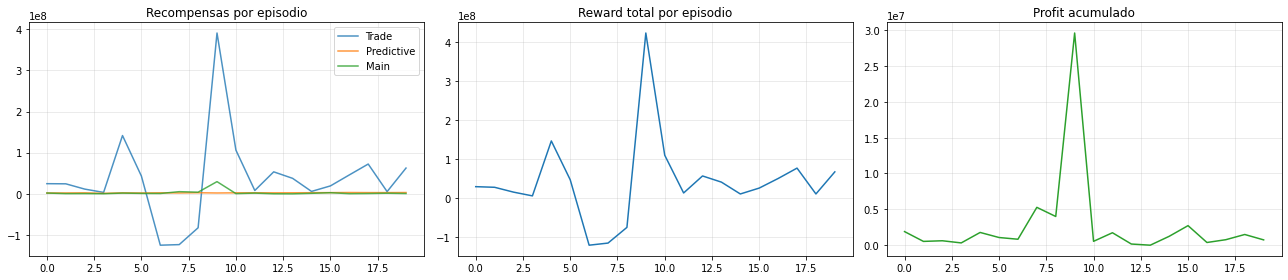

In [39]:
# Cargar datos
preprocessor = BitcoinPricePreprocessor()
df = preprocessor.load_data("btc_hourly.csv")
df = preprocessor.create_features(df)

# Cargar sentimientos
sentiment_data = TwitterSentimentSimulator().generate_sentiment()

# Dividir datos
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Crear agente NUEVO (los checkpoints anteriores son incompatibles con la normalización)
agent = DQNAgent()
# Si quieres cargar checkpoints entrenados CON normalización, descomenta:
start_episode = agent.load_checkpoint(".") + 1
# start_episode = 0

# Entrenar
EPISODES = 20
print(f"\nEntrenando M-DQN desde episodio {start_episode}...")
env = BitcoinTradingEnv(
    train_data, initial_balance=1_000_000, sentiment_data=sentiment_data
)
rewards, profits = train_mdqn(
    env, agent, episodes=EPISODES, start_episode=start_episode, log_freq=2000
)

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Rewards por componente
rh = np.array(rewards)
axes[0].plot(rh[:, 0], label="Trade", alpha=0.8)
axes[0].plot(rh[:, 1], label="Predictive", alpha=0.8)
axes[0].plot(rh[:, 2], label="Main", alpha=0.8)
axes[0].set_title("Recompensas por episodio")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reward total
axes[1].plot([sum(r) for r in rewards], color="tab:blue")
axes[1].set_title("Reward total por episodio")
axes[1].grid(True, alpha=0.3)

# Profit acumulado
axes[2].plot(profits, color="tab:green")
axes[2].set_title("Profit acumulado")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Checkpoint cargado: episodio 29 | Epsilon estimado: 0.8647

Evaluando M-DQN en datos de entrenamiento...
  RESULTADOS DE EVALUACIÓN (Test)
  Balance final:      $699,699.70
  BTC retenido:       961
  Valor total:        $41,594,535.76
  ROI:                +4059.45%
------------------------------------------------------------
  Reward TradeDQN:    1180238380.87
  Reward PredDQN:     3790197.67
  Reward MainDQN:     -71502.00
  Reward total:       1183957076.54
------------------------------------------------------------
  TRADES EJECUTADOS:
    Compras:          961
    Ventas:           0
    Holds:            0
------------------------------------------------------------
  DECISIONES DEL MODELO (diagnóstico):
    TradeDQN  → HOLD:     0 (0.0%)  BUY:     0 (0.0%)  SELL: 72463 (100.0%)
    MainDQN   → HOLD:     0 (0.0%)  BUY: 72463 (100.0%)  SELL:     0 (0.0%)
  ⚠️  El modelo compra pero NUNCA vende → no genera profit


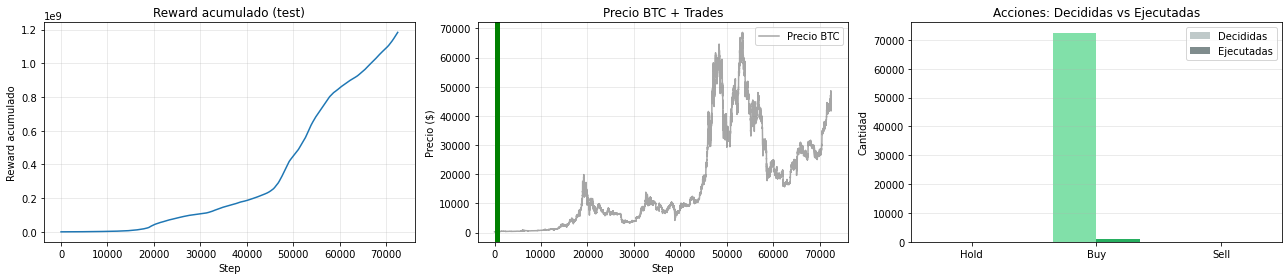

In [40]:
agent = DQNAgent()
start_episode = agent.load_checkpoint(".") + 1

# Evaluar
print("\nEvaluando M-DQN en datos de entrenamiento...")
test_results = test_mdqn(env, agent)